Shape train: (692500, 12)
Shape test : (296786, 12)
Accuracy en validación: 0.3930
CV Accuracy: 0.3919 ± 0.0008
Primeras filas del archivo submission:
       ID RENDIMIENTO_GLOBAL
0  550236               bajo
1   98545         medio-alto
2  499179               alto
3  782980               bajo
4  785185         medio-alto


C:\Users\gjcar\AppData\Local\Temp\ipykernel_18196\776079447.py:131: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.grid(); plt.tight_layout()


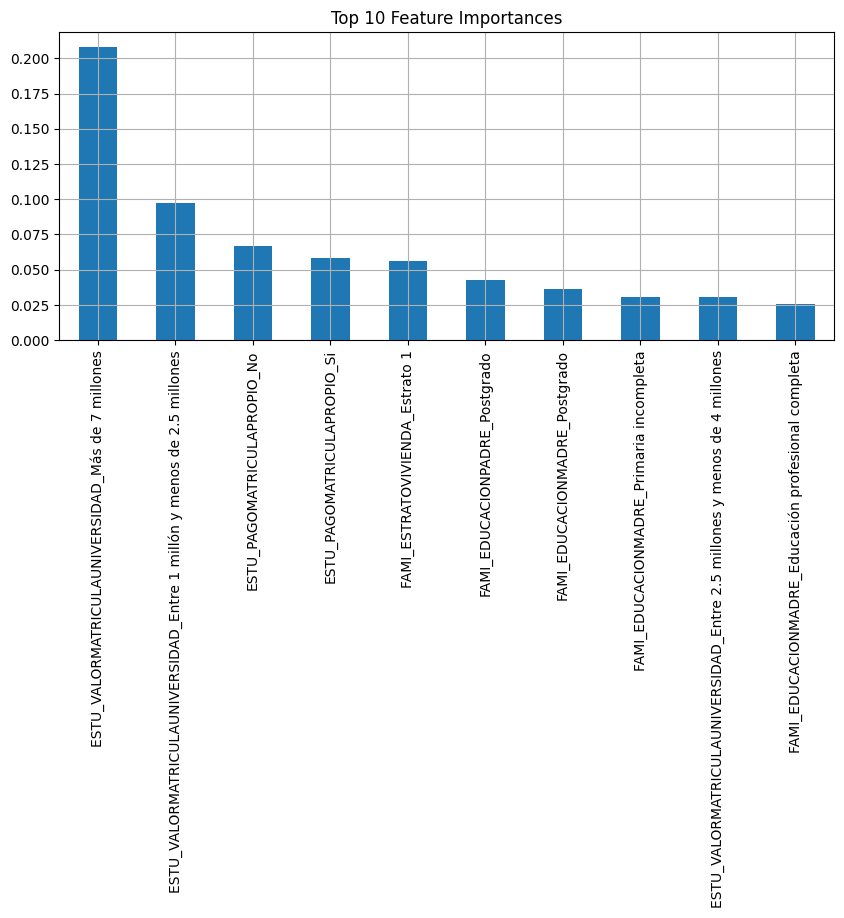

In [1]:
# =============================================
# 1. Librerías
# =============================================
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# =============================================
# 2. Cargar datos
# =============================================
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print("Shape train:", train.shape)
print("Shape test :", test.shape)

# =============================================
# 3. Selección de columnas socioeconómicas + académicas
# =============================================
cols = [
    'FAMI_ESTRATOVIVIENDA',
    'FAMI_TIENEINTERNET',
    'FAMI_EDUCACIONPADRE',
    'FAMI_EDUCACIONMADRE',
    'ESTU_VALORMATRICULAUNIVERSIDAD',
    'ESTU_HORASSEMANATRABAJA',
    'ESTU_PAGOMATRICULAPROPIO',
    'ESTU_PRGM_DEPARTAMENTO'
]

train = train[['ID'] + cols + ['RENDIMIENTO_GLOBAL']]
test = test[['ID'] + cols]

# =============================================
# 4. Limpieza de valores raros
# =============================================
valores_raros = ['98', '99', '999', 98, 99, 999]
for col in cols:
    train[col] = train[col].replace(valores_raros, np.nan)
    test[col] = test[col].replace(valores_raros, np.nan)

# =============================================
# 5. Imputación personalizada
# =============================================
imputacion = {
    'FAMI_ESTRATOVIVIENDA': 'Estrato 2',
    'FAMI_TIENEINTERNET': 'No',
    'FAMI_EDUCACIONPADRE': 'Secundaria (Bachillerato) completa',
    'FAMI_EDUCACIONMADRE': 'Secundaria (Bachillerato) completa',
    'ESTU_VALORMATRICULAUNIVERSIDAD': 'Entre 1 millón y menos de 2.5 millones',
    'ESTU_HORASSEMANATRABAJA': 'Entre 11 y 20 horas',
    'ESTU_PAGOMATRICULAPROPIO': 'No',
    'ESTU_PRGM_DEPARTAMENTO': 'ANTIOQUIA'
}

for col, valor in imputacion.items():
    train[col] = train[col].fillna(valor)
    test[col] = test[col].fillna(valor)

# =============================================
# 6. One-hot encoding
# =============================================
def one_hot(df, col):
    return pd.concat([df.drop(columns=[col]), pd.get_dummies(df[col], prefix=col)], axis=1)

for col in cols:
    train = one_hot(train, col)
    test = one_hot(test, col)

# Alinear columnas test con train
test = test.reindex(columns=train.drop(columns=['RENDIMIENTO_GLOBAL']).columns, fill_value=0)

# =============================================
# 7. Codificación de variable objetivo
# =============================================
mapa = {'bajo': 0, 'medio-bajo': 1, 'medio-alto': 2, 'alto': 3}
inv_mapa = {v: k for k, v in mapa.items()}
y = train['RENDIMIENTO_GLOBAL'].map(mapa)
X = train.drop(columns=['RENDIMIENTO_GLOBAL'])

# =============================================
# 8. División de datos
# =============================================
Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size=0.3, random_state=42)

# =============================================
# 9. Modelo Random Forest
# =============================================
clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
clf.fit(Xtrain, ytrain)

# =============================================
# 10. Evaluación
# =============================================
yval_pred = clf.predict(Xval)
acc = accuracy_score(yval, yval_pred)
print(f"Accuracy en validación: {acc:.4f}")
scores = cross_val_score(clf, X, y, cv=5)
print(f"CV Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

# =============================================
# 11. Predicción final
# =============================================
clf.fit(X, y)
y_pred = clf.predict(test)

# =============================================
# 12. Submission
# =============================================
submission = pd.DataFrame({
    'ID': test['ID'],
    'RENDIMIENTO_GLOBAL': pd.Series(y_pred).map(inv_mapa)
})

submission.to_csv("submission.csv", index=False)
print("Primeras filas del archivo submission:")
print(submission.head())

# =============================================
# 13. Importancia de variables
# =============================================
importances = clf.feature_importances_
feat_names = X.columns
feat_imp = pd.Series(importances, index=feat_names).sort_values(ascending=False)

top_n = 10
feat_imp.head(top_n).plot(kind='bar', figsize=(10, 4), title=f"Top {top_n} Feature Importances")
plt.grid(); plt.tight_layout()
